Use function approximation of utility function. It might not be the case that the true utility function can be represented in the chosen form. An evaluation function for chess represented as a weighted linear function of a set of features (or basis functions) $f_1, . . . , f_n$:
$$\hat U_\theta (s) = \theta_1 f_1(s) + \theta_2 f_2(s) + ··· + \theta_n f_n(s)$$

A reinforcement learning algorithm can learn values for the parameters $\theta = \theta_1, . . . , \theta_n$ such that the evaluation function $\hat U_\theta$ approximates the true utility function. Instead of, say, $10^{40}$ values in a table, this function approximator is characterized by, say, n = 20 parameters; an enormous compression. Although no one knows the true utility function for chess, no one believes that it can be represented exactly in 20 numbers. But if the approximation is good enough, the agent might still play excellent chess. We of course use an approximation because calculating exact utility would be infeasible. But we can still combine it with a certain amount of look-ahead search. 

Function approximation makes it practical to represent utility functions for very large state spaces, but that is not its principal beneﬁt. The compression achieved by a function approximator allows the learning agent to generalize from states it has visited to states it has not visited.

For reinforcement learning, we use an online learning algorithm that updates parameters after each trial. If $u_j(s)$ is the observed total reward from state s onward in jth trial, then the error is defined as: $E_j(s) = (\hat U_\theta (s) - u_j(s))^2 / 2$. The rate of change of the error with respect to each parameter $\theta_i$ is $\partial E_j / \partial \theta_i$, so to move the parameter in the direction of decreasing error, we want:
$$\theta_i \leftarrow \theta_i - \alpha \frac{\partial E_j(s)}{\partial \theta_i} = \theta_i + \alpha (u_j (s) - \hat U_\theta (s)) \frac{\partial \hat U_\theta (s)}{\partial \theta_i}$$
This is called the Widrow-Hoff or delta rule

An example utility function approximation could be $\hat U_\theta (s) = \theta_0 + \theta_1 \times \text{number_of_opponent pieces} + \theta_2 \times \text{number_of_your_pieces}$

Ensure that the basis functions that make up the utility function are linear in goodness/badness. If this is not the case, then transform them. i.e., instead of $x$ position of board, use $\left| x-x_{centre} \right|$

_______________________________________________________________________________________________________________________________
At time $t$, the environment is in state $s_t \in S$ with actions $A_{s_t}$ to choose from. Choosing $a_t \in A_{s_t}$ will take the state to $s_{t+1}$. At the terminal state $s_n$, a scalar reward $r(s_n)$ is given.
$$J^*(s) := E_{s_n|s}[r(s_n)]$$ 
$$a^*(s) := \arg \min_{a \in A_s}J^*(s'_a, {\bf w})$$
If we had $J^*$, then we could make optimal decisions. But we don't, so we approximate $J^*$ with $\bar J$ such that $\bar J$ is close to $J^*$ in the ordering of actions.
$$\bar J(s_n) := r(s_n)$$
$$d_t := \bar J(s_{t+1}, {\bf w}) - \bar J(s_t, {\bf w})$$
$$E_{s_{t+1}|s_t}[J^*(s_{t+1}) - J^*(s_t)]=0$$ 
At the end of the game, TD($\lambda$) updates ${\bf w}$ according to the following update rule:
$${\bf w} := {\bf w} + \alpha \sum_{t=1}^{n-1}{\nabla \bar J(s_t, {\bf w})\left[\sum_{j=t}^{n-1}{\lambda^{j-t}d_j}\right]}, 
\alpha > 0, \lambda \in [0, 1]$$
Can "anneal" $\alpha$ towards $0$ as learning continues. When $\lambda = 0$, TD($\lambda$) tries to minimise the difference between seqeuntial state evaluations. When $\lambda = 0$, $TD(\lambda)$ tries to minimise the difference between the $t^{\text{th}}$ state evaluation and the final result $r(s_n)$.
$$\lambda=0, {\bf w} := {\bf w} + \alpha \sum_{t=1}^{n-1}{\nabla \bar J(s_t, {\bf w})\left[\bar J(s_{t+1}, {\bf w}) - \bar J(s_t, {\bf w})\right]}$$
$$\lambda=1, {\bf w} := {\bf w} + \alpha \sum_{t=1}^{n-1}{\nabla \bar J(s_t, {\bf w})\left[r(s_n) - \bar J(s_t, {\bf w})\right]}$$
**Can try different $\lambda$s and compare learning rates**

TD($\lambda$) converges to near optimal play if $a(s_t)$ is independent of ${\bf w}$ (during training), and $\bar J(\cdot,{\bf w})$ is linear.
_______________________________________________________________________________________________________________________________
Let $\bar J_d(s, {\bf w})$ denote the evaluation for state s by applying $\bar J(s, {\bf w})$ to a depth of $d$. TD($\lambda$) is applied to leaf nodes in minimax search and this is called TDLeaf($\lambda$)

**It's very important to have good initial weights for near optimal and quick convergence, and also online play against human opponents**

Once a game has been played
- For each $s_i$, compute $\bar J_d(s_i, {\bf w})$ with minimax to depth $d$
- $s_i^l$ is the leaf node of the 'principle variation' from $s_i$: $\bar J_d(s_i, {\bf w}) = \bar J(s_i^l, {\bf w})$
- For $t \in \{1,...,n\}$

In [4]:
from hexapawn import State, INF, X, O, BLANK, N, DOWN, UP
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [300]:
games = []
w = np.array([1.0, -1, -1, 1, 1, -1] + [-1, -1, -1, 0, 0, 0, 1, 1, 1])
w /= len(w)
ws = [w]
𝜆 = 0.7
𝛼 = 0.1

In [301]:
def pieces(board, player):
    return board.count(player)/N

def n_at_back(board, player):
    if player == X:
        return board[:N].count(player)/N
    return board[N*(N-1):].count(player)/N

def n_at_2nd_back(board, player):
    if player == X:
        return board[N:2*N].count(player)/N
    return board[N*(N-2):N*(N-1)].count(player)/N

def J(b, w):
    return np.dot(np.array([pieces(b, X), pieces(b, O), n_at_back(b, X), n_at_back(b, O), 
                            n_at_2nd_back(b, X), n_at_2nd_back(b, O)] + [f(pos) for pos in b]),
                  w)

def f(pos):
    vals = {X: 1, BLANK: 0, O: -1}
    return vals[pos]

def best_move(state, player, printing=True):
    lst = []
    for a in state.actions():
        result = State(state.turn, state)
        result.move(a)
        lst.append((J(result.board, w), a))
    
    print(lst) if printing == True else None
    if player == X:
        return max(lst)[1] 
    else:
        return min(lst)[1]

def update(w, game, final_turn, 𝛼 = 0.1):
    final_state = State(final_turn, game[-1])
    n = len(game)
    rn = final_state.utility()
    dts = np.diff([J(game[i], w) for i in range(len(game))][:-1]+[rn])
    
    Δw = np.array([0.0]*len(w))
    for t in range(n-1):
        b = game[t]
        VJ = np.array([pieces(b, X), pieces(b, O), n_at_back(b, X), n_at_back(b, O), 
                       n_at_2nd_back(b, X), n_at_2nd_back(b, O)] + [f(pos) for pos in b])
        𝜆s = np.array([𝜆]*(n-1-t)) ** np.array([i for i in range(n-1-t)])
        𝜆dt = np.dot(𝜆s, dts[t:])
        Δw += VJ*𝜆dt
    w += 𝛼 * Δw

def play_game(turn=None, doUpdate=True):
    if turn is None:
        turn = np.random.choice([X, O])
        
    s = State(turn)
    print(s)
    
    states = []
    while s.terminal_test() is None:
        states.append(s.board)
        if s.turn == O:
            print('\n', list(enumerate(s.actions())), sep='')
            i = int(input())
            s.move(s.actions()[i])
        else:
            s.move(best_move(s, X, printing=False))
        
        print(s)
    print('\nGame Over!')
    states.append(s.board)
    games.append((states, s.turn))
    
    update(w, games[-1][0], games[-1][0])
    ws.append(np.copy(w))
    
def play_self(turn=None, doUpdate=True, 𝛼=0.1):
    if turn is None:
        turn = np.random.choice([X, O])
        
    s = State(turn)
    
    states = []
    while s.terminal_test() is None:
        states.append(s.board)
        s.move(best_move(s, s.turn, printing=False))
        
    states.append(s.board)
    games.append((states, s.turn))
    
    update(w, games[-1][0], games[-1][0], 𝛼)
    ws.append(np.copy(w))

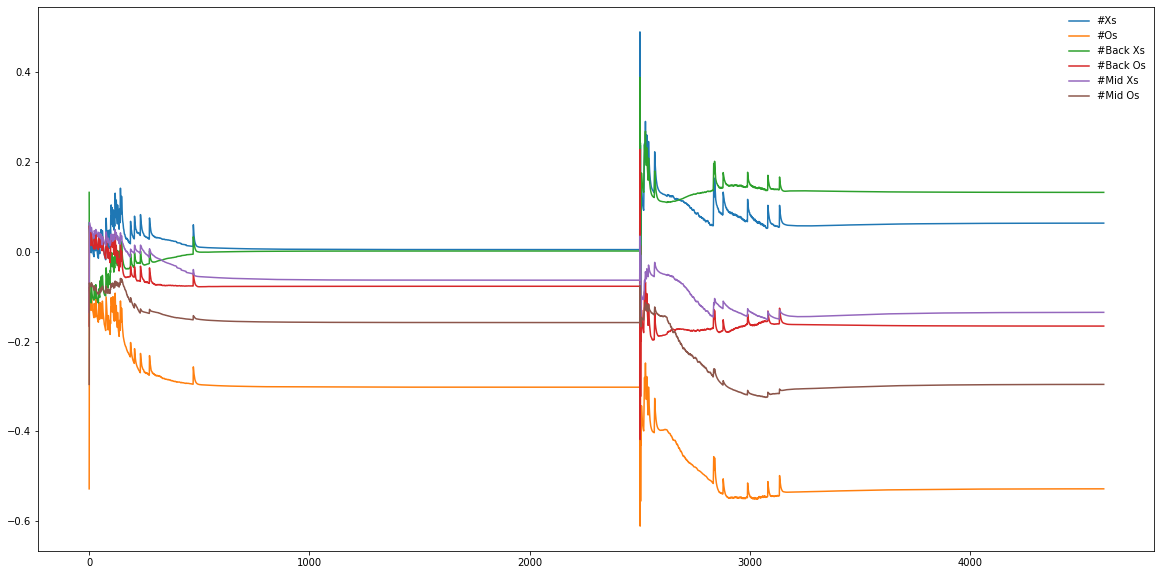

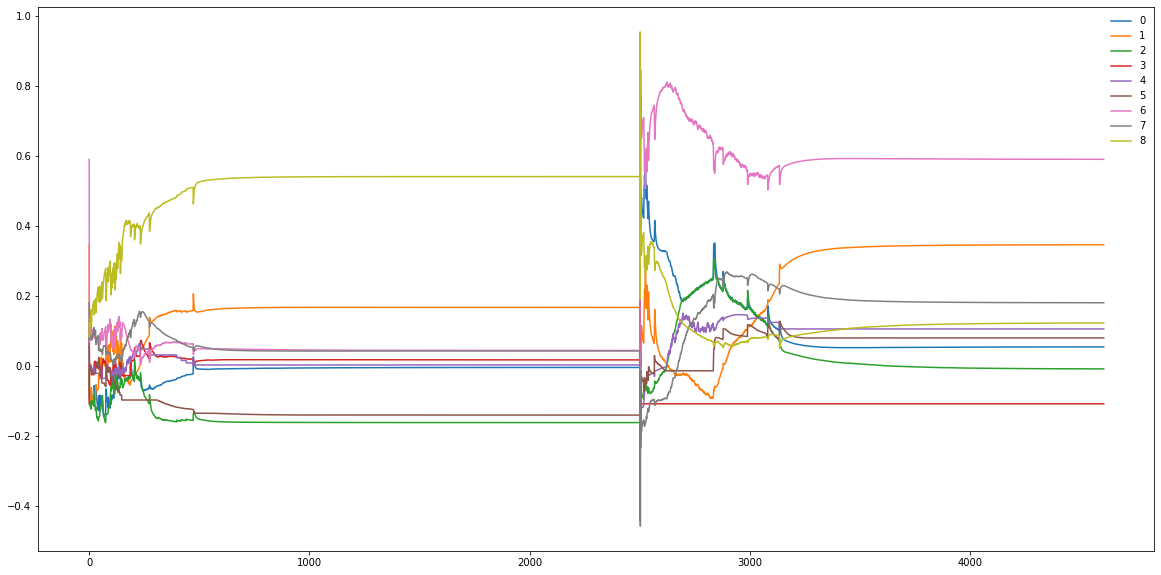

In [313]:
for i in range(1000):
    𝛼 = 0.01
    play_self(𝛼=𝛼)

fig, ax = plt.subplots(figsize=(20, 10))
lbls = ['#Xs', '#Os', '#Back Xs', '#Back Os', '#Mid Xs', '#Mid Os']
for i in range(6):
    x = [j for j in range(len(ws))]
    y = [ws[j][i] for j in range(len(ws))]
    ax.plot(x, y, label=lbls[i])
plt.legend(frameon=False)
plt.show()

fig, ax = plt.subplots(figsize=(20, 10))
lbls = [str(i) for i in range(N**2)]
for i in range(6, 6+9):
    x = [j for j in range(len(ws))]
    y = [ws[j][i] for j in range(len(ws))]
    ax.plot(x, y, label=lbls[i-6])
plt.legend(frameon=False)
plt.show()

In [312]:
play_game()

_______
|X|X|X|   0  1  2
| | | |   3  4  5
|O|O|O|   6  7  8
_______
|X|X| |   0  1  2
| | |X|   3  4  5
|O|O|O|   6  7  8

[(0, (6, 3)), (1, (7, 4)), (2, (7, 5))]
2
_______
|X|X| |   0  1  2
| | |O|   3  4  5
|O| |O|   6  7  8
_______
|X| | |   0  1  2
| | |X|   3  4  5
|O| |O|   6  7  8

[(0, (6, 3))]
0
_______
|X| | |   0  1  2
|O| |X|   3  4  5
| | |O|   6  7  8

Game Over!
[ 0.0608403  -0.53004397  0.13286877 -0.16440241 -0.13869513 -0.2989749
  0.05367939  0.34332593  0.00160099 -0.10708053  0.10673848  0.08118134
  0.59313759  0.18569261  0.11437704]
